# Spatial indexing

This notebook discusses the notions spatial indexing. It starts with the notions of distance and neighborhood, and how the underlying calculations are performed using a direct or "brute force" approach. A second part is dedicated to the most found spatial structures: voxel grids, octree, and k-d trees.

In [101]:
# Necessary imports
import sys
import time
import heapq
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("./utils")
from plot_utils import cells_to_rect, plot_voxel, cuboid_to_poly3D

## About distances and neighborhoods

### Distances

The notion of distance $d$ is considered here as **the length between two points** noted $p$ and $q$. This is a measurement of "how far apart these two points are".

The most used and intuitive distance in our case is the Euclidean distance, which is defined by:
\begin{equation*}
d(p, q) = \sqrt{(p_x - q_x)^2 + (p_y - q_y)^2 + (p_z - q_z)^2}
\end{equation*}

As shown below, it corresponds to a straight line between points.

The Euclidean distance between these two points is equal to: 69.7


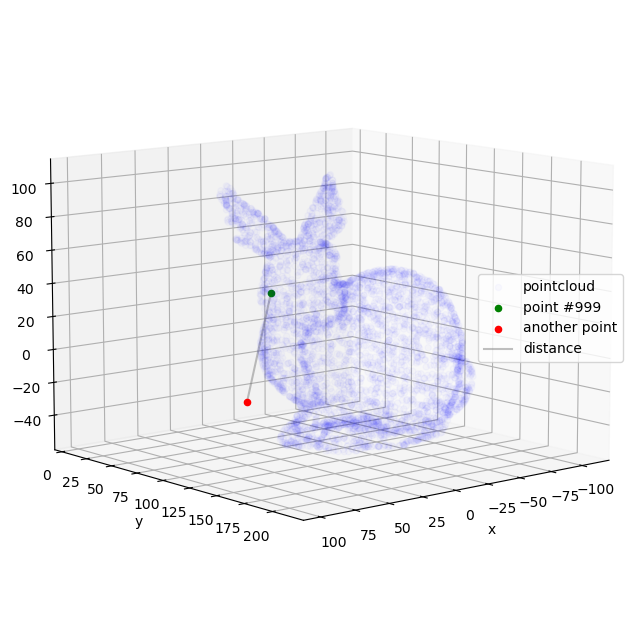

In [102]:
# Load pointcloud
points = np.loadtxt("./data/stanford_bunny_simple.xyz")
# Create another point
another_point = np.array([90., 150., -10.])
# Distance
point_999 = points[999]
dist = np.linalg.norm(point_999 - another_point) # this is equivalent to np.sqrt(np.sum((point_99 - point_other)**2))
print("The Euclidean distance between these two points is equal to: {:.1f}".format(dist))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],
          color="blue", alpha=0.02, label="pointcloud")
ax.scatter(point_999[0], point_999[1], point_999[2],
          color="green", label="point #999")
ax.scatter(another_point[0], another_point[1], another_point[2],
          color="red", label="another point")
ax.plot([another_point[0], point_999[0]], [another_point[1], point_999[1]], [another_point[2], point_999[2]],
          color='gray', alpha=0.5, label="distance")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 50)
plt.axis("equal")
plt.show()


However, note that in a *metric space*, such as the 3-dimensional Euclidean space considered here, a distance is merely a function satisfying the following conditions:
* positivity $d(a, b) \geq 0$
* symmetry $d(a, b) = d(b, a)$
* separation $d(a, b) = 0 \iff a = b$
* triangular inequality $d(a, c) \leq d(a, b) + d(b, c)$

As consequence, other types of distance might be encountered, such as the *taxicab* or *Manhattan* or 1-distance, given by:
\begin{equation*}
d_{1}(p, q) = |p_x - q_x| + |p_y - q_y| + |p_z - q_z|
\end{equation*}
or the *Chebyshev* or *maximum* or $\infty$-distance, given by:
\begin{equation*}
d_{\infty}(p, q) = \max(|p_x - q_x|, |p_y - q_y|, |p_z - q_z|)
\end{equation*}

The Euclidean distance mentioned earlier is also called the 2-distance. For higher numbers, distance is referred to as *Minkowski* or $p$-distance.

Note also that distances may be expressed as norms such as $d_{n}(p, q) = ||p - q||_{n}$ (in practice, if $n$ is omitted you can consider that this is the Euclidean distance).

### Neighborhoods

The notion of neighborhood is roughly defined as **the set of points in the vicinity of a query point** (noted $q$). Two types of neighborhood are considered in practice: those with a fixed distance and those with a fixed number of points.

The first one is called a *spherical* neighborhood (and the associated search is often referred to as *ball query*), as all points within a radius $r$ of $q$ are selected:
\begin{equation*}
N_{r}(q) = \{ p \in P : d(p, q) < r \}
\end{equation*}

Unlike the first one, for which the number of neighbors is not known in advance, the second neighborhood results in a fixed-size set of the $k$-nearest-neighbors of $q$ or knn.

Let's see now how neighborhoods may be computed in practice!

In [103]:
# Define the query point for the rest of the notebook
query_point = another_point
# Set the parameters k and r for the rest of the notebook
k = 5
r = 50


## The "brute force" approach

The most immediate approach for computing neighborhoods is called the "brute force approach".

It is fairly simple and only consists in a few steps:
1. Computing the distance between the query point and all the points of the pointcloud
2. Sorting the points by distance to the query point
3. Selecting the $k$ closest points or points within a distance inferior to the search radius $r$

An example is given below.

Closest 5 points of the pointcloud to 'another point' are points # [ 183  893 3550   53  221]
Points within r are points # [  53  183  221  268  287  436  449  893 1135 1342 1402 1900 1952 2002
 2014 2216 2369 2399 3106 3550 3663 4021 4057]


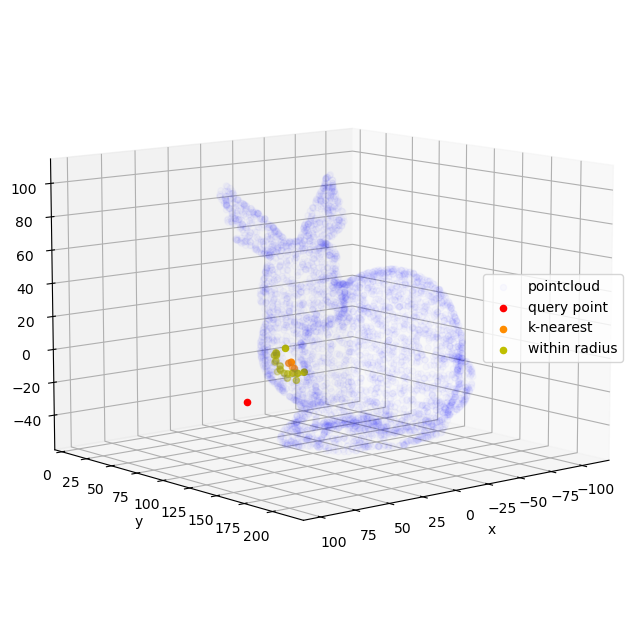

In [104]:
def brute_force_search(points, query_point, k):

    # Compute distances to the query point
    dists = np.linalg.norm(points - query_point, axis=1)
    # Sort the points by distance
    sorted_inds = np.argsort(dists)
    # Select the k closest points
    return sorted_inds[:k]

def brute_force_ball_search(points, query_point, r):

    # Compute distances to the query point
    dists = np.linalg.norm(points - query_point, axis=1)
    # Select points within a radius r
    return np.argwhere(dists < r).flatten()

# Try brute force search
knn_brute_force = brute_force_search(points, query_point, k)
with np.printoptions(precision=2, suppress=True):
    print("Closest 5 points of the pointcloud to 'another point' are points #", knn_brute_force)

# Try brute force ball search
ball_seach_brute_force = brute_force_ball_search(points, query_point, r)
print("Points within r are points #", ball_seach_brute_force)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],
          color="blue", alpha=0.02, label="pointcloud")
ax.scatter(query_point[0], query_point[1], query_point[2],
          color="red", label="query point")
ax.scatter(points[knn_brute_force, 0], points[knn_brute_force, 1], points[knn_brute_force, 2],
          color="darkorange", label="k-nearest")
ball_seach_brute_force_fig = np.setdiff1d(ball_seach_brute_force, knn_brute_force) # do not repeat points
ax.scatter(points[ball_seach_brute_force_fig, 0], points[ball_seach_brute_force_fig, 1], points[ball_seach_brute_force_fig, 2],
          color="y", label="within radius")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 50)
plt.axis("equal")
plt.show()


While conceptually simple, note that this approach is however quite inefficient.

Indeed it basically requires to compute the distance between the query point and each point of the pointcloud. This results in $n^2$ calculations (if already computed distances are not stored, which would be very memory consuming for large pointclouds) in case that a neighborhood needs to be computed for each point of a pointcloud of size $n$ (which is often needed for estimating local properties such as normals or curvatures). Thus **the brute force approach is not recommended for large pointclouds** (typically starting from a few thousands of points).

We can see that the main source of inefficiency of this approach lies in the fact that distances are systematically computed, irrespective of how far apart points may be. That's why the idea of using data structures based on the points position came into play.

## Spatial structures

The idea that lies behind spatial structures is quite intuitive: **partitioning the 3D space in different "regions" that contain a subset of the pointcloud**. The notion of region helps to guide the neighborhood search by focusing only on the points that are "close enough" to the query point (disregarding the others that are "too far").


### Voxel grid

A first and quite simple way to partition the 3D space around a pointcloud is to use a *regular grid*. This grid is said to be regular if it consists of cells (or "chunks") of equal size, which corresponds to cubes or *voxels* in a three-dimensional space. The word voxel comes from the fusion between volume and pixel and is thus to 3D what a pixel is to 2D. **A voxel grid is then a set of voxels that contain the points of the pointcloud**.

In practice, using a voxel grid may be seen as putting points into numbered cubic boxes. The search for neighbors then becomes easier as it is limited to looking into a limited number of boxes (i.e., voxels) around the one containing the query point (think about a cabinet with drawers).

Let's see now how voxel grids may be built in practice!

In [105]:
# Set the cell size for the rest of the notebook
cell_size = 20.

A prior step into building a voxel grid is to define a consistent way to name or number the voxels. There are of course many possibilities, but a simple one consists in using the position of its bottom-left corner on the grid. For example, for a voxel size of $20$ (edges have a length of 20), a voxel numbered $(1, 2, 3)$ would start at position $[1, 2, 3]$ on the grid, which correspond to position $[20., 40., 60.]$ in the main coordinate system.

Once the naming convention has been defined, the voxel grid can be built using the following steps:
1. Associate each point of the pointcloud to a voxel, that is $p_i \in V_{(a, b,c)}$
2. Fill the voxels with the points, that is $V_{(a, b, c)} = \{p_i, p_j, ...\}$

There are also several type of data structure that may be used to build a voxel grid in practice. A simple way consists in using a *hash table* or a *dictionary*, with the *keys* being the identifiers of the voxels (name or number) and the *values/buckets* being the list of the points they contain. In practice, it is easier to store the point indices into the voxels (rather than the points coordinates) to simplify the update if the pointcloud is altered (addition or removal of points). Note that empty voxels (i.e., voxels that do not contain any points) are not explicitly represented (stored) using this technique.

Let's illustrate this with a 2D example first!

Point # 0 with coordinates [-25.5861  42.684 ] is associated with cell # [(-2, 2)]
Cell # (-2, 2) contains points # [0, 72, 73, 128, 153, 197, 203, 283, 449, 470]


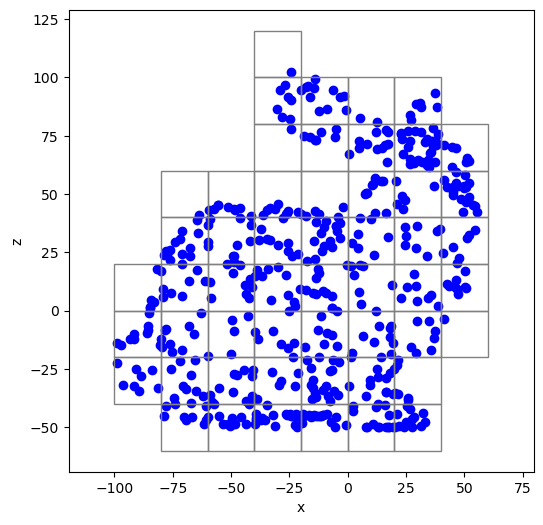

In [106]:
def points_to_cells(points, cell_size):

    # Works also for individual points
    if points.ndim==1: 
        points = points.reshape((1, -1))
    # Bottom-left corner position on the grid
    cell_coords = (points//cell_size).astype(int)
    # Lists or arrays cannot be dict keys so we use tuples instead
    return [tuple(c) for c in cell_coords]

def create_cell_grid(points, cell_size):

    # Associate each point to a cell
    cell_coords = points_to_cells(points, cell_size)
    # Create a dict with {coord:[points]}
    cell_grid = {}
    for i, coord in enumerate(cell_coords):
        cell = cell_grid.setdefault(coord, []) # create the cell if it does not already exist
        cell.append(i) # store point index in the cell
    
    return cell_grid

# Create a 2D pointcloud
points_sample_2d = points[::8, [0,2]] # keep one 8th of points and only the x and z coordinates

# Check the first point
print(f"Point # {0} with coordinates {points_sample_2d[0]} is associated with cell # {points_to_cells(points_sample_2d[0], cell_size)}")

# Create a 2D grid (of squares/pixels)
cell_grid_2d = create_cell_grid(points_sample_2d, cell_size)
# Check the first voxel
print("Cell # {} contains points # {}".format(*list(cell_grid_2d.items())[0]))

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.scatter(points_sample_2d[:, 0], points_sample_2d[:, 1],
          color="blue")
rectangles = cells_to_rect(cell_grid_2d, cell_size)
for rect in rectangles:
    ax.add_patch(rect)
ax.set_xlabel('x')
ax.set_ylabel('z')
plt.axis("equal")
plt.show()


The process is exactly the same in 3D.

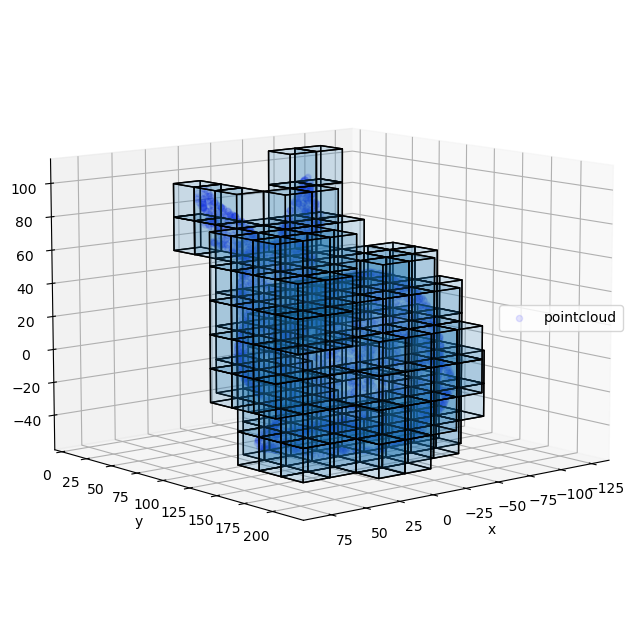

In [107]:
# Build voxel grid
cell_grid_3d = create_cell_grid(points, cell_size)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],
          color="blue", alpha=0.1, label="pointcloud")
pc = plot_voxel(cell_grid_3d.keys(), cell_size, edgecolor="k", alpha=0.1)
ax.add_collection3d(pc)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 50)
plt.axis("equal")
plt.show()


Note that **a voxel grid constitutes a kind of 3D representation in itself**, just like a pointcloud or a mesh. Voxels grids are typically used in areas such as volumetric imaging (in medicine or materials science), video games or simulation.

As mentioned before, a parallel can be drawn between voxels grids and images, which are respectively 3D and 2D regular grids. Just like images, voxels grids may have different channels for colors (such as red, green, and blue), but also for other types of information.

Continuing with our parallel, note that a square image of one megapixel (i.e., one million pixels) would have a shape of $(1000*1000)$ while an "image" of one "megavoxel" would have a shape of $(100*100*100)$. It means that high-resolution and dense (i.e., without empty voxels) voxel grids are usually quite heavy to store and process. The fact that adding an extra dimension (from 2D to 3D) results in increasing dramatically the data volume is called *the curse of dimensionality*.

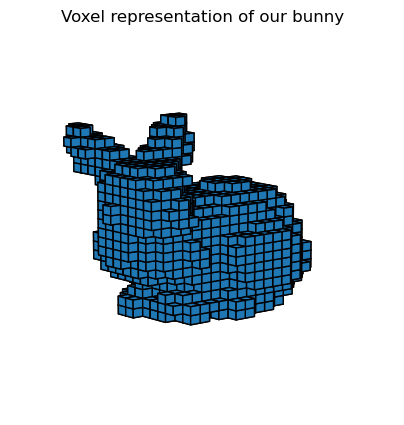

In [108]:
def voxelize_pointcloud(points, grid_length):

    # Deduce the appropriate voxel size
    cell_size = points.ptp(axis=0).max() / grid_length
    # Compute voxels
    voxel_rep = np.unique((points//cell_size).astype(int), axis=0)
    # Make sure that voxels have positive coordinates (similar to pixels in images)
    voxel_rep -= voxel_rep.min(axis=0)

    return voxel_rep, cell_size

# Choose the number of voxels in each direction (x, y, and z)
grid_length_rep = 20
# Voxelize
voxel_rep, cell_size_rep = voxelize_pointcloud(points, 20.)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection="3d")
pc = plot_voxel(voxel_rep, cell_size_rep, edgecolor="k")
ax.add_collection3d(pc)
ax.set_xlim(right=cell_size_rep*grid_length_rep)
ax.set_ylim(top=cell_size_rep*grid_length_rep)
ax.set_zlim(top=cell_size_rep*grid_length_rep)
ax.view_init(10, 50)
ax.set_axis_off()
ax.set_title("Voxel representation of our bunny")
plt.show()


Voxel grids may also be used for other purposes such as subsampling.

As explained in the first notebook, subsampling aims to decrease the size of the pointcloud. An approach consists in selecting points to keep/remove at random, but this gives in a very irregular resulting pointcloud. On the other hand, it is possible to rely on spatial structures to achieve more regular results.

As often, several options may be considered. A first one would consist in selecting one or a few points per voxel. These points can be selected at random, or according to any other rule (e.g., the closest points to the voxel center). Another option consists in replacing the points in each voxel by a unique point that would summarize their properties. We can think for example of averaging the points coordinates (position, but also colors and so on). Note that in the second option, the original pointcloud is rather "simplified" than subsampled.


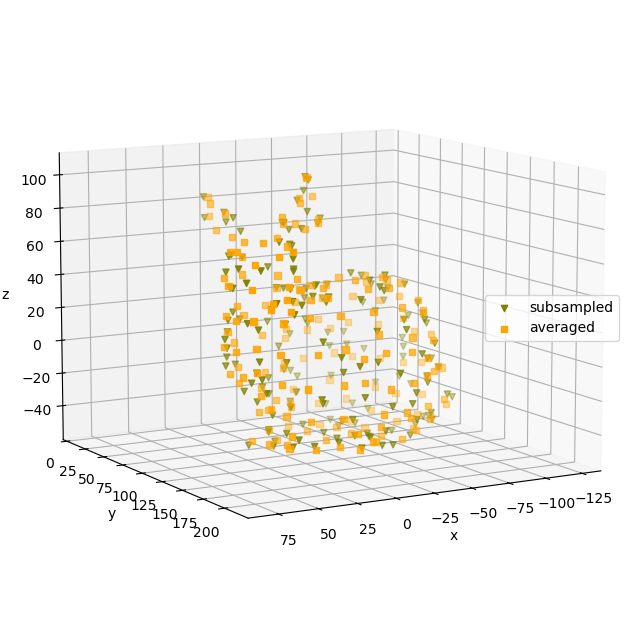

In [109]:
def subsample_grid(points, cell_grid):

    random_inds = np.array([np.random.choice(inds) for inds in cell_grid.values()])
    
    return points[random_inds]

def average_grid(points, cell_grid):

    avg_points = np.array([points[inds].mean(axis=0) for inds in cell_grid.values()])
    
    return avg_points

# Try subsample
points_grid_sub = subsample_grid(points, cell_grid_3d)

# Try average
points_grid_avg = average_grid(points, cell_grid_3d)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points_grid_sub[:, 0], points_grid_sub[:, 1], points_grid_sub[:, 2],
           c='olive', marker="v", label="subsampled")
ax.scatter(points_grid_avg[:, 0], points_grid_avg[:, 1], points_grid_avg[:, 2],
           c='orange', marker="s", label="averaged")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 60)
plt.axis("equal")
plt.show()


After this digression, let's return to the neighborhood search!

As stated before, the main advantage in using a spatial structure is that the search is limited only to points that are not "too far away" from the query point. In this case, these points would be contained in **the voxels that are the closest to the query point**.

In practice, one option consists in determining the voxel coordinates associated with the query point (i.e., the voxel in which the query point "would fall", whether this voxel already contains points or not) and computing the distance with the other voxels in the voxel grid.

But how to define distance between voxels? Consider a 2D pixel, its immediate neighborhood is composed of 8 cells (cardinal directions NW, N, NE, W, E, SW, S, and SE). A 3D voxel has then 26 (8 + 9 + 9) immediate neighbors. We may refer to these neighborhoods as 1-neighborhoods and extend this reasoning to superior orders (i.e., 2-neighborhoods, 3-neighborhoods, etc.). Note this is distantly linked to the concept of *Moore neighborhood* used in cellular automata theory. In this case, using the grid coordinates defined earlier, the $p$-neighborhood of a given cell is made up of cells located at a Chebyshev distance of $p$.

This idea is implemented below.

In [110]:
def cell_neighborhoods(query_cell, cells, max_range=np.inf):
    """Categorize cells by distance to the query_cell (with optional limit)"""

    # Make sure to use Numpy arrays to speed-up calculations
    query_cell = np.asarray(query_cell, dtype=int)
    cells = np.asarray([*cells], dtype=int)
    # Chebyshev distance
    dists = np.linalg.norm(query_cell - cells, ord=np.inf, axis=1)
    # Easier stored using a dict
    neighborhoods = {}
    for d, c in zip(dists, cells):
        if d > max_range: continue
        cell = neighborhoods.setdefault(int(d), [])
        cell.append(tuple(c))

    return neighborhoods

# Example
query_cell_ex = (0, 0, 0)
cells_ex = [(i, j, k) for i in range(-2, 3) for j in range(-2, 3) for k in range(-2, 3)] # create a voxel grid of size (5*5*5) centered around (0, 0, 0)
p_neighborhoods_ex = cell_neighborhoods(query_cell_ex, cells_ex)
print("The 1-neighborhood of cell", query_cell_ex, "is composed of cells :", p_neighborhoods_ex.get(1))


The 1-neighborhood of cell (0, 0, 0) is composed of cells : [(-1, -1, -1), (-1, -1, 0), (-1, -1, 1), (-1, 0, -1), (-1, 0, 0), (-1, 0, 1), (-1, 1, -1), (-1, 1, 0), (-1, 1, 1), (0, -1, -1), (0, -1, 0), (0, -1, 1), (0, 0, -1), (0, 0, 1), (0, 1, -1), (0, 1, 0), (0, 1, 1), (1, -1, -1), (1, -1, 0), (1, -1, 1), (1, 0, -1), (1, 0, 0), (1, 0, 1), (1, 1, -1), (1, 1, 0), (1, 1, 1)]


Now that distances between cells can be computed, let's go back to the k-nearest neighbors' search!

The most straightforward approach is the following, considering a target point:
1. Determining in which voxel this point falls
2. Looking within the neighboring voxels while increasing the order/distance $p$
3. Stopping when the target number of points $k$ is reached
4. Including the $p+1$-neighborhood (to make sure that no points are missed)
5. Performing a brute-force search on the points included in the neighboring voxels


In [111]:
def grid_search(points, cell_grid, query_point, k):

    # Determine in which cell the query point falls
    query_cell = (query_point//cell_size).astype(int)
    
    # Compute the query cell neighborhoods
    query_cell_neighborhoods = cell_neighborhoods(query_cell, cell_grid.keys())
    
    # Incrementally explore the cell neighborhoods
    candidate_inds = []
    # Increase the distance p at each step
    for p in sorted(query_cell_neighborhoods.keys()):
        # Add the points indices contained in the cells
        for neighboring_cell in query_cell_neighborhoods[p]:
            candidate_inds.extend(cell_grid[neighboring_cell])
        
        # Stop when the target number of points is reached
        if len(candidate_inds) >= k:
            for neighboring_cell in query_cell_neighborhoods[p+1]:
                candidate_inds.extend(cell_grid[neighboring_cell])
            candidate_inds = np.asarray(candidate_inds)
            break
    
    # Perform a brute force search
    closest_candidates = brute_force_search(points[candidate_inds], query_point, k)
    
    return candidate_inds[closest_candidates]

# Using our example
knn_voxel_grid = grid_search(points, cell_grid_3d, query_point, k)
with np.printoptions(precision=2, suppress=True):
    print("Closest 5 points of the pointcloud to 'another point' are points #", knn_voxel_grid)
print("knn are the same than those computed with brute force:", not np.setdiff1d(knn_voxel_grid, knn_brute_force).size)


Closest 5 points of the pointcloud to 'another point' are points # [ 183  893 3550   53  221]
knn are the same than those computed with brute force: True


For ball search, the most straightforward approach is the following, considering a target point:
1. Determining in which voxel this point falls
2. Determining the voxels that are within the radius $r$
3. Performing a brute-force search on the points included in the neighboring voxels


In [112]:
def grid_ball_search(points, cell_grid, cell_size, query_point, r):

    # Determine in which cell the query point falls
    query_cell = (query_point//cell_size).astype(int)
    
    # Compute the query cell neighborhoods
    max_range = r//cell_size + 1
    p_neighborhoods = cell_neighborhoods(query_cell, cell_grid_3d.keys(), max_range)
    cells_within_max_range = [cell for p_cells in p_neighborhoods.values() for cell in p_cells]

    # Add the points indices contained in the cells
    candidate_inds = np.array([inds for cells in cells_within_max_range for inds in cell_grid_3d[cells]])

    # Perform a brute force search
    inds_within_r = brute_force_ball_search(points[candidate_inds], query_point, r)

    return candidate_inds[inds_within_r]

# Using our example
ball_seach_voxel_grid = grid_ball_search(points, cell_grid_3d, cell_size, query_point, r)
print("Points within r are points #", ball_seach_voxel_grid)
print("Points within r are the same than those computed with brute force:", not np.setdiff1d(ball_seach_voxel_grid, ball_seach_brute_force).size)


Points within r are points # [  53  183  221  436  449  893 1135 1342 1402 1952 2216 2399 3663  268
  287 1900 2002 2014 2369 3106 3550 4057 4021]
Points within r are the same than those computed with brute force: True


It's easy to see why using a voxel grid is in theory more efficient than a brute force approach, as only a fraction of the initial pointcloud is considered during the search.

There is however **a major parameter to consider, that is the voxels size**. Remember that it was the only parameter used to build our voxel grid.

Let's see how this size affects the speed of the neighborhood search!

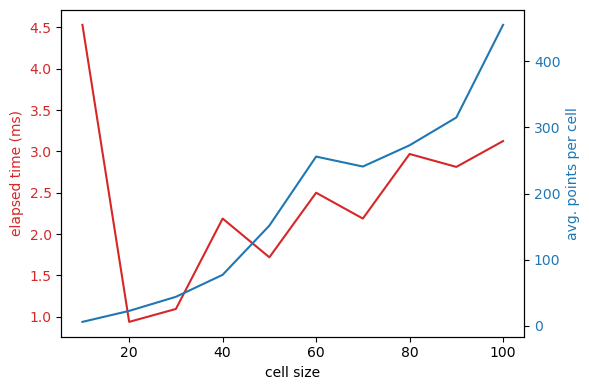

In [113]:
# Try different grid sizes
sizes = [s for s in range(10, 110, 10)]
# Measure time for knn search and average number of points per cell
elapsed_time = []
points_per_cell = []
for s in sizes:
    # Time for grid creation is not considered
    grid = create_cell_grid(points, s)
    points_per_cell.append(np.mean([len(c) for c in grid.values()]))
    # Consider multiple runs
    elapsed_time_runs = []
    for _ in range(1000):
        start_time = time.process_time()
        grid_search(points, grid, query_point, k)
        end_time = time.process_time()
        elapsed_time_runs.append(end_time-start_time)
    elapsed_time.append(np.mean(elapsed_time_runs)*10e3)

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot()
ax1.set_xlabel("cell size")
ax1.set_ylabel('elapsed time (ms)', color='tab:red')
ax1.plot(sizes, elapsed_time, color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax2 = ax1.twinx()
ax2.set_ylabel('avg. points per cell', color="tab:blue")
ax2.plot(sizes, points_per_cell, color="tab:blue")
ax2.tick_params(axis='y', labelcolor="tab:blue")
fig.tight_layout()
plt.show()


Even if the right part is less steep (due to the smallness of the considered pointcloud), we can clearly see a "U-shape" curve for the elapsed time. On the left part, the number of voxels that are necessary to consider during the search is too high to offer a significant speed-up (imagine the extreme case of only one point per voxel, this is equivalent to a brute-force search among points). On the right time, only a few voxels are considered, but they contain a large portion of the pointcloud (imagine the extreme case of only one voxel containing the entire pointcloud, this is again equivalent to a brute-force search among points).

It is then paramount to choose the correct voxels size so that the neighbors search is as efficient as possible. As a rule of thumb, **begin with voxel size giving about 50 points per voxel on average at first**, and try other sizes from there. However, the correct size is also highly dependent of the average number of neighbors to query or the radius size, this is not an exact science.

To sum up, voxel grids are a nice kind of spatial structure but suffer some limitations. That is why hierarchical structures are preferred in practice.

### Octree

An octree is a **hierachical 8-ary tree structure** that is used to efficiently store and manipulate 3D objects of various types, as described in the following reference article:

Meagher, D. (1982). Geometric modeling using octree encoding. *Computer graphics and image processing*, 19(2), 129-147.

More precisely, an octree is a tree (i.e., a connected and acyclic graph) in which each *inner node* has exactly eight children (only its *root node* has no parents and its *leaves* have no children). Its use for spatial applications involves **recursively subdivising the 3D space containing the objects of interest into eight equal parts**, also known as octants. While implementation details may vary (but we'll come to that later), each node usually stores some information about the 3D objects it encloses (here 3D points), its geometry (here the volume that encloses the points), and its position within the tree.

Let's first begin with a 2D implementation for an easier understanding! The 2D equivalent of the octree is called a quadtree. Here the 2D space is recursively subdivided into four equal pieces called quadrants. A quite straightfoward implementation is proposed below.

Each node stores the index of points it encloses, the minimum and maximum coordinates (i.e., the position of bottom-left and top-right corners) of the axis-aligned-rectangle, and the list of its children. The tree is first constructed by creating a root node. This root node contains all points of the pointcloud and its geometry corresponds to the pointcloud bounding box. The tree is then expanded by splitting this root node and its children. This expansion process stops when each leaf node contains no more than a certain number of points (the minimum being, of course, one point per leaf). Note that other criteria, such a the *depth* of the octree or the maximum number of subdivisions allowed may also be used to control the shape of the octree.


In [114]:
class QuadTree:
    """Partition 2D space by recursively subdividing it into four quadrants."""
    
    class QuadNode:
        """A node of our QuadTree or quadrant."""

        def __init__(self, bounds, indices):

            self.bounds = bounds # Position of bottom-left and top-right corners
            self.indices = indices # Store point indices instead of coordinates
            self.children = [] # Assume terminal node by default

        @property
        def geometry(self):
            """Geometry of the node as a rectangle."""

            bound_min, bound_max = self.bounds
            anchor_point = bound_min
            length, width = bound_max - bound_min
            
            return anchor_point, length, width
        
        @property
        def is_leafnode(self):
            """A terminal/leaf node does not have children."""

            return not len(self.children)

    def __init__(self, points, leafsize=10):

        self.points = points
        self.leafsize = leafsize
        # Create root node
        bounding_box = (points.min(axis=0), points.max(axis=0))
        indices = np.arange(len(points), dtype=int)
        self.root = QuadTree.QuadNode(bounding_box, indices)
        # Recursively build the tree
        self._split_node(self.root)
    
    def _split_node(self, node):
        """Recursively split a node into four subnodes/children."""

        # Do not split if node is already too small
        if len(node.indices) < self.leafsize:
            return
        # Compute the bounds of the four candidate subnodes
        x_center, y_center = (node.bounds[1] + node.bounds[0])/2
        x_min, y_min = node.bounds[0]
        x_max, y_max = node.bounds[1]
        new_bounds = [ 
            # South-West
            (np.array([x_min, y_min]), np.array([x_center, y_center])),
            # North-West
            (np.array([x_min, y_center]), np.array([x_center, y_max])),
            # Nord-East
            (np.array([x_center, y_center]), np.array([x_max, y_max])),
            # South-East
            (np.array([x_center, y_min]), np.array([x_max, y_center]))
        ]
        # Compute the node points falling into each subnode
        for (b_min, b_max) in new_bounds:
            in_subnode = np.logical_and(
                (self.points[node.indices] >= b_min).all(axis=1), 
                (self.points[node.indices] <= b_max).all(axis=1)
            )
            # A subnode is created only if it contains some points
            if np.any(in_subnode):
                subnode = QuadTree.QuadNode((b_min, b_max), node.indices[in_subnode])
                node.children.append(subnode)
                # Split this subnode further (until children are too small)
                self._split_node(subnode)

    @property
    def nodes(self):
        """List of QuadNodes composing our QuadTree."""

        quadtree_nodes = []
        # Explore the tree using breadth-first search
        queue = [self.root]
        while len(queue):
            node = queue.pop(0)
            for subnode in node.children:
                if subnode not in quadtree_nodes:
                    quadtree_nodes.append(subnode)
                    queue.append(subnode)
        
        return quadtree_nodes


As observed below, the size of the 2D cells or quadrants depends on the local density of the pointcloud. 

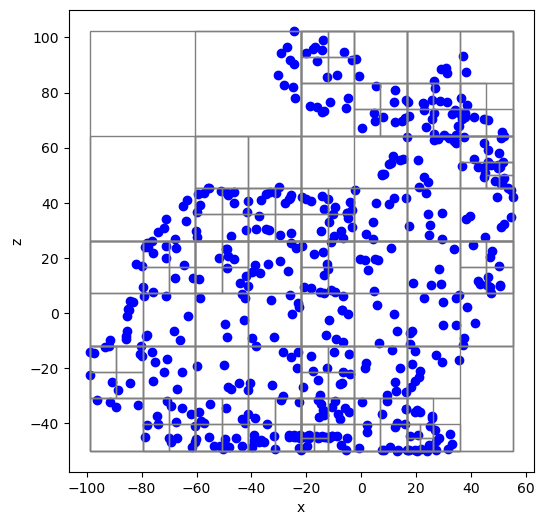

In [115]:
# Build quadtree
quadtree = QuadTree(points_sample_2d)

from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.scatter(points_sample_2d[:, 0], points_sample_2d[:, 1],
          color="blue")
for node in quadtree.nodes:
    anchor_point, length, width = node.geometry    
    rect = Rectangle(anchor_point, length, width, color="gray", fill=False, lw=1)
    ax.add_patch(rect)
ax.set_xlabel('x')
ax.set_ylabel('z')
plt.axis("equal")
plt.show()

The principles outlined above for the construction of our quadtree can be reused quite straigtforwardly for the construction of our octree.

In [ ]:
class OcTree:
    """Partition 3D space by recursively subdividing it into eight octants."""
    
    class OctNode:
        """A node of our Octree or octant."""

        def __init__(self, bounds, indices):

            self.bounds = bounds # Position of bottom-left and top-right corners
            self.indices = indices # Store point indices instead of coordinates
            self.children = [] # Assume terminal node by default

        @property
        def geometry(self):
            """Geometry of the node as a rectangular cuboid."""

            bound_min, bound_max = self.bounds
            anchor_point = bound_min
            length, width, height = bound_max - bound_min
            
            return anchor_point, length, width, height
        
        @property
        def is_leafnode(self):
            """A terminal/leaf node does not have children."""

            return not len(self.children)

        def is_inside(self, point):
            """Check if a point is inside the node/cuboid."""

            return np.logical_and(
                (point >= self.bounds[0]).all(), 
                (point <= self.bounds[1]).all()
            )

        def distance(self, point):
            """Distance between a point and the cuboid."""
           
            deltas = np.max([[0., 0., 0.], self.bounds[0] - point, point - self.bounds[1]], axis=0)
            
            return np.linalg.norm(deltas)

    def __init__(self, points, leafsize=10):

        self.points = points
        self.leafsize = leafsize
        # Create root node
        bounding_box = (points.min(axis=0), points.max(axis=0))
        indices = np.arange(len(points), dtype=int)
        self.root = OcTree.OctNode(bounding_box, indices)
        # Recursively build the tree
        self._split_node(self.root)
    
    def _split_node(self, node):
        """Recursively split a node into four subnodes/children."""

        # Do not split if node is already too small
        if len(node.indices) < self.leafsize:
            return
        # Compute the bounds of the four candidate subnodes
        x_center, y_center, z_center = (node.bounds[1] + node.bounds[0])/2
        x_min, y_min, z_min = node.bounds[0]
        x_max, y_max, z_max = node.bounds[1]
        new_bounds = [ 
            # South-West-Back
            (np.array([x_min, y_min, z_min]), np.array([x_center, y_center, z_center])),
            # North-West-Back
            (np.array([x_min, y_min, z_center]), np.array([x_center, y_center, z_max])),
            # Nord-East-Back
            (np.array([x_min, y_center, z_center]), np.array([x_center, y_max, z_max])),
            # South-East-Back
            (np.array([x_min, y_center, z_min]), np.array([x_center, y_max, z_center])),
            # South-West-Front
            (np.array([x_center, y_min, z_min]), np.array([x_max, y_center, z_center])),
            # North-West-Front
            (np.array([x_center, y_min, z_center]), np.array([x_max, y_center, z_max])),
            # Nord-East-Front
            (np.array([x_center, y_center, z_center]), np.array([x_max, y_max, z_max])),
            # South-East-Front
            (np.array([x_center, y_center, z_min]), np.array([x_max, y_max, z_center]))
        ]
        # Compute the node points falling into each subnode
        for (b_min, b_max) in new_bounds:
            in_subnode = np.logical_and(
                (self.points[node.indices] >= b_min).all(axis=1), 
                (self.points[node.indices] <= b_max).all(axis=1)
            )
            # A subnode is created only if it contains some points
            if np.any(in_subnode):
                subnode = OcTree.OctNode((b_min, b_max), node.indices[in_subnode])
                node.children.append(subnode)
                # Split this subnode further (until children are too small)
                self._split_node(subnode)

    @property
    def nodes(self):
        """List of QuadNodes composing our OcTree."""

        octree_nodes = []
        # Explore the tree using breadth-first search
        queue = [self.root]
        while len(queue):
            node = queue.pop(0)
            for subnode in node.children:
                if subnode not in octree_nodes:
                    octree_nodes.append(subnode)
                    queue.append(subnode)
        
        return octree_nodes
    
    def search(self, query_point, k):
        """Nearest neighbors search."""

        nearest_neighbors = []
        # Dive into the tree
        priority_queue = []
        heapq.heappush(priority_queue, (0, self.root))
        while priority_queue:
            # Select the node with the smallest distance
            dist, node = heapq.heappop(priority_queue)
            # If it's a leaf node, check all points in it
            if node.is_leafnode:
                for idx in node.indices:
                    point = self.points[idx]
                    point_dist = np.linalg.norm(point - query_point)
                    if len(nearest_neighbors) < k:
                        heapq.heappush(nearest_neighbors, (-point_dist, idx))
                    else:
                        if point_dist < -nearest_neighbors[0][0]:
                            heapq.heappop(nearest_neighbors)
                            heapq.heappush(nearest_neighbors, (-point_dist, idx))
            else:
                # Else, add child nodes to the priority queue
                for child in node.children:
                    child_dist = child.distance(query_point)
                    heapq.heappush(priority_queue, (child_dist, child))

        # Extract the indices of the k nearest neighbors
        return [idx for _, idx in sorted(nearest_neighbors, reverse=True)]

    def ball_search(self, query_point, r):
        """Search neighbors within a radius"""

        neighbors_within_radius = []
        # Dive into the tree
        queue = [self.root]
        while len(queue):
            node = queue.pop(0)
            # Only consider nodes that are within a radius r of the query point
            if node.distance(query_point) <= r:
                # If it's a leaf node, check all points in it
                if node.is_leafnode:            
                    # Compute distances to the query point
                    dists = np.linalg.norm(self.points[node.indices] - query_point, axis=1)
                    # Select points within a radius r
                    inds_within_r = node.indices[np.argwhere(dists < r).flatten()]
                    # Add to list of neighbors
                    neighbors_within_radius.extend(inds_within_r.tolist())
                # Else, add child nodes to the queue
                else:
                    queue.extend(node.children)
    
        return neighbors_within_radius



Let's visualize our octree first and then focus on our neighborhood search!


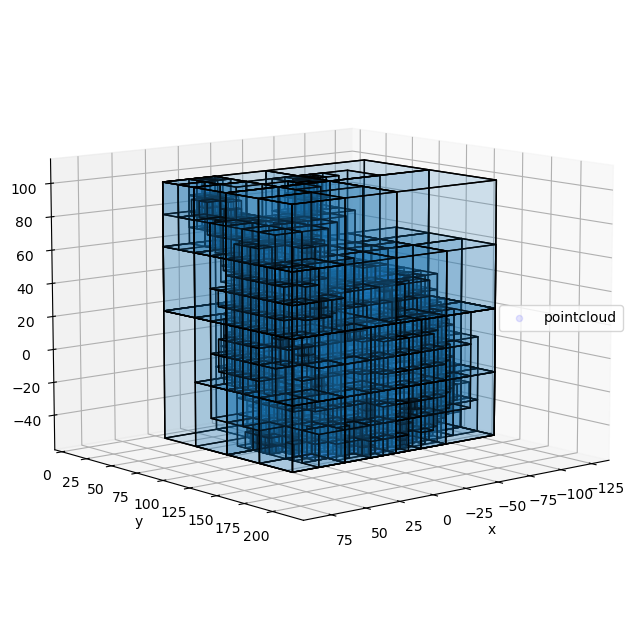

In [117]:
# Build octree with our 3D pointcloud
octree = OcTree(points)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],
          color="blue", alpha=0.1, label="pointcloud")

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

polys = []
for octnode in octree.nodes:
    anchor_point, length, width, height = octnode.geometry
    polys.append(cuboid_to_poly3D(anchor_point, (length, width, height)))

polys = np.concatenate(polys)

pc = Poly3DCollection(polys, edgecolor="k", alpha=0.1)

ax.add_collection3d(pc)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 50)
plt.axis("equal")
plt.show()

The $k$ nearest neighbors search is done as follows:
1. Traverse down the tree until reaching the leaf node that contains the query point or is the closest to it.
2. Search the leaf node and store the $k$ closest points and their distances.
3. Traverse the tree back up and explore additional nodes if the distance to their bounding box is less than the largest distance previously stored.



In [118]:
knn_search_octree = octree.search(query_point, k)
print("Points within r are points #", knn_search_octree)
print("Points within r are the same than those computed with brute force:", not np.setdiff1d(knn_search_octree, knn_brute_force).size)

Points within r are points # [183, 893, 3550, 53, 221]
Points within r are the same than those computed with brute force: True


The ball search is done as follows:
1. Traverse down the tree discarding nodes with distance (bounding boxes) greater than the radius $r$.
2. Search the remaining leaf nodes and store points whose distance is less than $r$.

In [119]:

ball_search_octree = octree.ball_search(query_point, r)
print("Points within r are points #", ball_search_octree)
print("Points within r are the same than those computed with brute force:", not np.setdiff1d(ball_search_octree, ball_seach_brute_force).size)


Points within r are points # [4021, 449, 1952, 2216, 3663, 1402, 4057, 221, 2014, 2369, 3550, 268, 3106, 287, 436, 1135, 1342, 1900, 2002, 2399, 53, 183, 893]
Points within r are the same than those computed with brute force: True


As explained above, the use of an octree reduces the search space significantly by focusing only on relevant regions. Its hierarchical nature allows data storage at different levels of resolution, which offers more flexibility than voxel grids for example. 

Also note that there are not an unique way of implementing an octree in practice. In particular, several data structures may be used to store the nodes of the octree. The most straigtforward is of course a tree, in which links (or *pointers*) from parents to children explicitely express the hierarchical structure of the octree. This is the case in the implementation above. Another option uses a *hash table* (or a dictionnary in Python) to associate each node with a unique identifier or code, which implicitely corresponds to its positioning within the tree. For instance, each node is assigned a 3-bit number (between 0 and 7), that is added to its parent's number to form its unique (octonary) code. The result is often called a *linear octree*, in reference to the *linear quadtree* proposed in:

Gargantini, I. (1982). An effective way to represent quadtrees. *Communications of the ACM*, 25(12), 905-910.

One major advantage is that linear octrees are less memory-intensive (no need to store the links between nodes) and make some operations quite straigtforward to perform (e.g., traversing the octree up by a simply repeatedly removing the last 3-bits from the node code/number). However, "regular" octrees make structural modifications (i.e., the addition/deletion of nodes) more easier.

Another differences in implementation may also include the representation of "empty zones" or nodes/cells aspect ratio. In particular, *full octrees* have exactly $8^d$ leaf nodes (with $d$ the number of subdivisions of depth) while *sparse octrees* do not have "empty" nodes (i.e., not containing any geometry). The first ones are usefull if space must be fully mapped (note also that nodes may be stored as a simple list of size $\sum 8^d$) while the later are more memory efficient and a little more complex (e.g., "missing nodes" may have to be added later if needed). The octree nodes (or cells) may also be have different shapes, the most commons being axis-aligned cubes or arbitrarily sized boxes. The first one are guaranteed to have the same dimension in every direction, easing some calculations and saving some memory.


### kd-tree


A kd-tree is...

Bentley, J. L. (1975). Multidimensional binary search trees used for associative searching. *Communications of the ACM*, 18(9), 509-517.


In [120]:
class KdTree:
    
    class KdNode:

        def __init__(self, bounds, points):

            self.bounds = bounds # Position of bottom-left and top-right corners
            self.points = points
            self.children = [] # Assume terminal node by default

        @property
        def geometry(self):
            """Geometry of the node as a hyper-rectangle."""

            bound_min, bound_max = self.bounds
            anchor_point = bound_min
            dimensions = bound_max - bound_min
            
            return anchor_point, dimensions
        
        @property
        def is_leafnode(self):
            """A terminal/leaf node does not have children."""

            return not len(self.children)

    
    def __init__(self, points, leafsize=10):

        self.points = points
        self.leafsize = leafsize
        self.k = points.shape[-1] # the dimension or k of the k-d tree
        # Create root node
        bounding_box = (points.min(axis=0), points.max(axis=0))
        self.root = KdTree.KdNode(bounding_box, points)
        # Recursively build the tree
        self._split_node(self.root, split_dim=0)
    
    def _split_node(self, node, split_dim):
        """Recursively split a node into two subnodes."""

        # Do not split if node is already too small
        if len(node.points) < self.leafsize:
            return
        # Compute the midpoint along the split direction
        split_val = np.median(node.points[:, split_dim])
        # Compute the bound of the two subnodes
        b_min, b_max = node.bounds
        b_mid_min = np.copy(b_min)
        b_mid_min[split_dim] = split_val
        b_mid_max = np.copy(b_max)
        b_mid_max[split_dim] = split_val
        new_bounds = [         
            (b_min, b_mid_max), # Left
            (b_mid_min, b_max), # Right
        ]
        # Compute the node points falling into each subnode
        for (b_min_new, b_max_new) in new_bounds:
            points_in_subnode = np.logical_and(
                (node.points >= b_min_new).all(axis=1), 
                (node.points <= b_max_new).all(axis=1)
            )
            # The split guarantees that a subnode contains some points
            subnode = KdTree.KdNode((b_min_new, b_max_new), node.points[points_in_subnode])
            node.children.append(subnode)
            # Split this subnode further (until children are too small)
            new_split_dim = (split_dim + 1) % self.k
            self._split_node(subnode, new_split_dim)

    @property
    def nodes(self):
        """List of KdNodes composing our KdTree."""

        kdtree_nodes = []
        # Explore the tree using breadth-first search
        queue = [self.root]
        while len(queue):
            node = queue.pop(0)
            for subnode in node.children:
                kdtree_nodes.append(subnode)
                queue.append(subnode)
        
        return kdtree_nodes

    def search(self, query_point, k):
        """Nearest neighbors search."""
        
        return

    def ball_search(self, query_point, r):
        """Search neighbors within a radius."""

        def _ball_search_recursive(node, query_point, r, neighbors):
            """Recursive helper function for ball search."""
            if node.is_leafnode:
                # Check all points in the leaf node
                for point in node.points:
                    if np.linalg.norm(point - query_point) <= r:
                        neighbors.append(point)
                return
            
            # Check child nodes
            for child in node.children:
                child_min, child_max = child.bounds
                # Check if the bounding box of the child intersects the search sphere
                if np.all(query_point - r <= child_max) and np.all(query_point + r >= child_min):
                    _ball_search_recursive(child, query_point, r, neighbors)

        neighbors = []
        _ball_search_recursive(self.root, query_point, r, neighbors)
        
        return np.array(neighbors)


As observed below, the size of the 2D cells or quadrants depends on the local density of the pointcloud. 

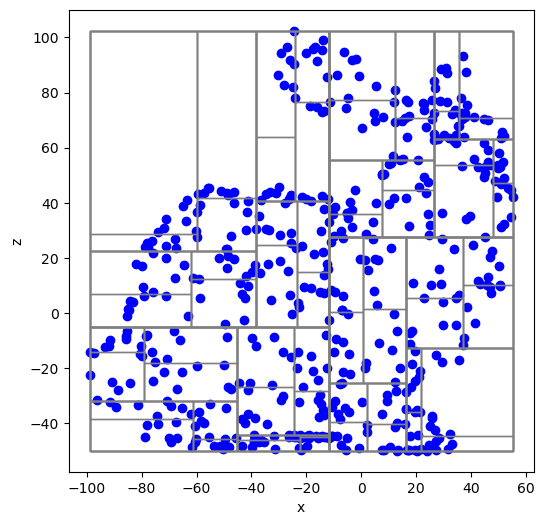

In [121]:
# Build kdtree
kdtree = KdTree(points_sample_2d)

from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.scatter(points_sample_2d[:, 0], points_sample_2d[:, 1],
          color="blue")
for node in kdtree.nodes:
    anchor_point, dimensions = node.geometry
    length, width = dimensions
    rect = Rectangle(anchor_point, length, width, color="gray", fill=False, lw=1)
    ax.add_patch(rect)
ax.set_xlabel('x')
ax.set_ylabel('z')
plt.axis("equal")
plt.show()

3D visualization

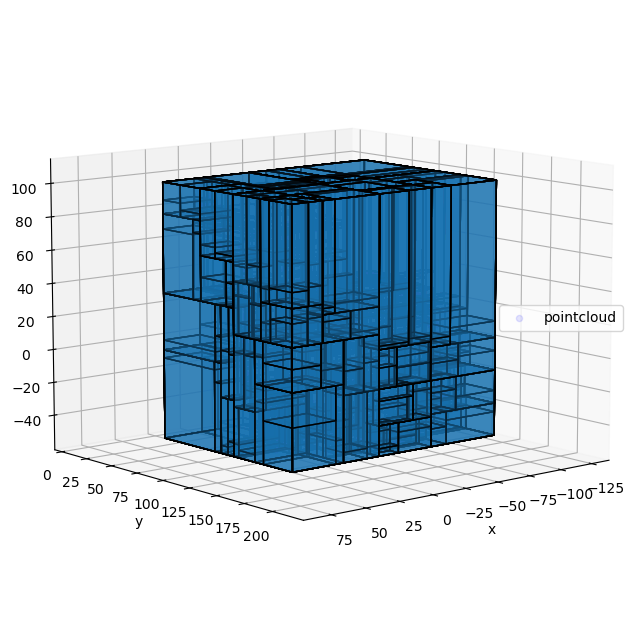

In [122]:
# Build kdtree with our 3D pointcloud
kdtree = KdTree(points)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],
          color="blue", alpha=0.1, label="pointcloud")

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

polys = []
for kdnode in kdtree.nodes:
    anchor_point, dimensions = kdnode.geometry
    length, width, height = dimensions
    polys.append(cuboid_to_poly3D(anchor_point, (length, width, height)))

polys = np.concatenate(polys)

pc = Poly3DCollection(polys, edgecolor="k", alpha=0.1)

ax.add_collection3d(pc)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 50)
plt.axis("equal")
plt.show()

Nearest neighbors search

In [123]:
knn_search_kdtree = kdtree.search(query_point, k)
print("Points within r are points #", knn_search_kdtree)
print("Points within r are the same than those computed with brute force:", not np.setdiff1d(knn_search_kdtree, knn_brute_force).size)

Points within r are points # None
Points within r are the same than those computed with brute force: False


Ball search

In [124]:
ball_search_kdtree = kdtree.ball_search(query_point, r)
print("Points within r are points #", ball_search_kdtree)
print("Points within r are the same than those computed with brute force:", not np.setdiff1d(ball_search_kdtree, ball_seach_brute_force).size)


Points within r are points # [[ 4.571520e+01  1.321510e+02 -2.173200e+00]
 [ 4.662570e+01  1.302407e+02 -2.064300e+00]
 [ 4.738730e+01  1.279048e+02 -6.106000e-01]
 [ 4.487070e+01  1.308799e+02 -5.092100e+00]
 [ 4.755510e+01  1.251395e+02 -1.795500e+00]
 [ 4.932250e+01  1.249912e+02  4.098300e+00]
 [ 4.828430e+01  1.285336e+02  2.219200e+00]
 [ 5.064700e+01  1.260848e+02  8.426400e+00]
 [ 4.988230e+01  1.265806e+02  5.145900e+00]
 [ 5.043400e+01  1.273149e+02  1.013290e+01]
 [ 5.050510e+01  1.279689e+02  9.673500e+00]
 [ 4.750650e+01  1.273347e+02  1.185000e-01]
 [ 5.058930e+01  1.278979e+02  8.648700e+00]
 [ 4.902510e+01  1.343077e+02  1.349220e+01]
 [ 4.246430e+01  1.361457e+02 -5.829100e+00]
 [ 4.596740e+01  1.367678e+02  2.363700e+00]
 [ 4.763540e+01  1.355605e+02  4.807300e+00]
 [ 4.539120e+01  1.378879e+02  1.830800e+00]
 [ 4.698940e+01  1.370839e+02  5.493300e+00]
 [ 4.427970e+01  1.394148e+02 -9.592000e-01]
 [ 4.521180e+01  1.358429e+02 -1.306200e+00]
 [ 4.508410e+01  1.375240e

Synthesis

## Wrapping up

Final notes